In [7]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from random import choices

# define class for building
class Building:
    def __init__(self, id, geometry, bld_type):
        self.id = id
        self.geometry = geometry
        self.bld_type = bld_type

# importing osm location
address = "Çimentepe Mahallesi"
buildings = ox.features.features_from_address(address, tags={'building': True}, dist=350)

# creating object for each building
bld_lst = []
for i in buildings.index:
    id = i[1]
    geo = buildings.loc[i, 'geometry']
    bld_type = buildings.loc[i, 'building']

    bld = Building(id, geo, bld_type)
    bld_lst.append(bld)

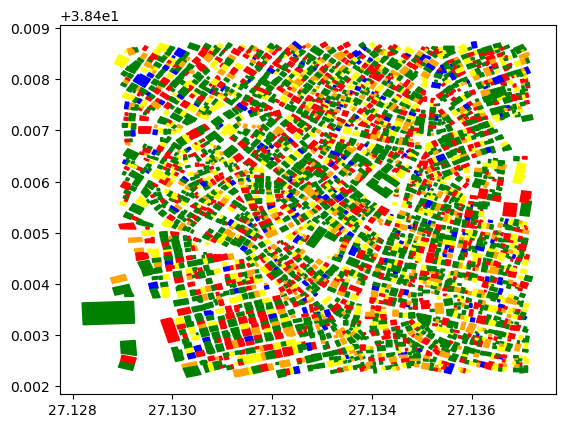

In [8]:

# save each geometry attribute in a list
geos = [o.geometry for o in bld_lst]

# plot each geometry in the subplot
fig, ax = plt.subplots()

# population = [0, 1, 2, 3, 4]
population = ['green', 'blue', 'yellow', 'orange', 'red']
weights = [0.45, 0.05, 0.15, 0.12, 0.23]

for g in geos:
    c = choices(population, weights)[0]
    x, y = g.exterior.xy
    ax.fill(x, y, color = c)

# Display the plot
plt.show()

In [29]:
import rhino3dm as rs

c_pts = []
for geo in geos:
    points = []
    for point in geo.exterior.coords:
        x, y = point
        rh_point = rs.Point3d(x, y, 0)
        points.append(rh_point)
    c_pts.append(points)
polygon = rs.Curve.CreateControlPointCurve(c_pts)
print(polygon[0])
           


RuntimeError: Unable to cast Python instance to C++ type (compile in debug mode for details)

In [28]:
"""Hops flask middleware example"""
import sys
import os
from flask import Flask
from PIL import Image
import rhino3dm as rs

# load ghhops-server-py source from this directory
import ghhops_server as hs

# register hops app as middleware
app = Flask(__name__)
hops: hs.HopsFlask = hs.Hops(app)

# flask app can be used for other stuff directly
@app.route("/help")
def help():
    return "Welcome to Grashopper Hops for CPython!"


@app.route("/update", methods=["POST"])
def update():
    return "Update example!"

# component
@hops.component(
    "/imft",
    name="ImportFootprints",
    nickname="IF",
    description="Import Building Footprints",
    outputs=[hs.HopsPoint("Footprints", "F", "List of footprints imported")]
)

def import_footprints():
    c_pts = []
    for geo in geos:
        points = []
        for point in geo.exterior.coords:
            x, y = point
            rh_point = rs.Point3d(x, y, 0)
            points.append(rh_point)
        c_pts.append(points)
    polygon = rs.Curve.CreateControlPointCurve(c_pts)
    return hs.HopsCurve(polygon)

if __name__ == "__main__":
    app.run()


 * Serving Flask app "__main__" (lazy loading)


 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


[INFO]  * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
[INFO] 127.0.0.1 - - [12/Oct/2023 14:08:47] "GET /imft HTTP/1.1" 200 -
[INFO] 127.0.0.1 - - [12/Oct/2023 14:08:47] "GET /imft HTTP/1.1" 200 -
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1ddd0a31040>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1ddd0a317c0>
[INFO] Solving using legacy API: <HopsComponent /imft [ -> ImportFootprints -> Footprints] >
[INFO] 127.0.0.1 - - [12/Oct/2023 14:08:47] "POST /solve HTTP/1.1" 200 -
